In [57]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba import jit
import model
import importlib
model = importlib.reload(model)
from common import constraints, cosmology

In [58]:
@jit(nopython=True)
def pot(theta, f_a, T, params):
    m, g = params
    return 0.5 * m**2 * f_a**2 * theta**2 + g * (f_a * theta)**4

@jit(nopython=True)
def pot_deriv(theta, f_a, T, params):
    m, g = params
    return m**2 * theta + g * f_a**2 * theta**3

model.add_pot("with_self_coupling", pot, pot_deriv)

f_a = 3e14
H_inf = 2e10

In [52]:
def calc_end_time(g, m_a, f_a, Gamma_phi, H_inf, num_osc):
    to_osc = lambda E: 1/(2*E) if Gamma_phi >= m_a else 2/(3*E)
    axion_period = lambda E: 2*np.pi/E
    t_osc_m = to_osc(m_a)
    E_g = np.sqrt(g) * f_a
    t_osc_g = to_osc(E_g)
    t_start = 1 / H_inf
    def end_time(E):
        t_end = to_osc(E) + axion_period(E) * num_osc
        if t_end < t_start:
            return t_start * 10
        else:
            return t_end
    if t_osc_m < t_osc_g:
        return end_time(E_g)
    else:
        return end_time(m_a)
    
def calc_axion_periode(g, m_a, f_a, Gamma_phi):
    E_g = np.sqrt(g) * f_a
    if E_g > m_a:
        return 2*np.pi / E_g
    else:
        return 2*np.pi / m_a

In [53]:
Gamma_phi = 1e8
m_a = 1e7
f_a = 2e10
H_inf = constraints.calc_H_inf_max(f_a)
g_range = np.geomspace(1e-4, 1e0, 20)
n = 15

In [34]:
eta_B_s = np.array([model.compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf, "with_self_coupling", (m_a, g),
                    bg_kwargs=dict(end=calc_end_time(g, m_a, f_a, Gamma_phi, n), 
                                   inc=calc_axion_periode(g, m_a, f_a, Gamma_phi) * n)) 
                     for g in tqdm(g_range)])

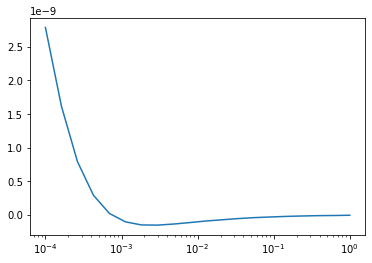

In [35]:
plt.semilogx(g_range, eta_B_s)

In [54]:
calc_end_time(g, m_a, f_a, Gamma_phi, H_inf, n), cosmology.calc_start_time(H_inf)

(9.474777960769379e-06, 8.333333333333333e-08)

20000000000.0

In [62]:
g = 1e-4
sol = model.simulate(f_a=f_a, Gamma_phi=Gamma_phi, H_inf=H_inf, pot_name="with_self_coupling", params=(m_a, g),
              end=calc_end_time(g, m_a, f_a, Gamma_phi, H_inf, n), 
              inc=calc_axion_periode(g, m_a, f_a, Gamma_phi) * n)

In [64]:
g = 0
sol_h = model.simulate(f_a=f_a, Gamma_phi=Gamma_phi, H_inf=H_inf, pot_name="with_self_coupling", params=(m_a, g),
              end=calc_end_time(g, m_a, f_a, Gamma_phi, H_inf, n), 
              inc=calc_axion_periode(g, m_a, f_a, Gamma_phi) * n)

<ipython-input-52-06422fb787e0>:2: RuntimeWarning: divide by zero encountered in double_scalars
  to_osc = lambda E: 1/(2*E) if Gamma_phi >= m_a else 2/(3*E)
<ipython-input-52-06422fb787e0>:3: RuntimeWarning: divide by zero encountered in double_scalars
  axion_period = lambda E: 2*np.pi/E
/home/jana/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/jana/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


KeyboardInterrupt: 

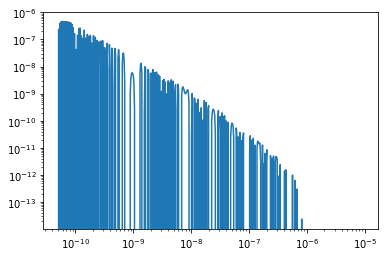

In [63]:
plt.loglog(sol.t, cosmology.n_L_to_eta_B_final(sol.T, sol.n_L))